# RSI ETF Strategy #


The project’s primary objective was to create an ETF portfolio by reconstructing a popular hedge fund strategy and employing the Relative Strength Index (RSI) as the primary buy/sell trigger. Tracking each underlying stock regulated the transfers of capital between stocks and the portfolio itself. After considerations were applied the model was run through real life scenarios resulting in calculated cumulative returns which were compared to ETF returns.


#### Considerations ####

- Dividends – The model’s calculations had to adhere to ex dividends, record dates, etc.
- Reinvestment capital – Cash balance was recalculated daily and applied for subsequent trades.
- Transaction fees (Adjustable parameter)
- Management fees (Adjustable parameter) – Percentage of annual portfolio.
- RSI signals – Based on adjustable parameters.
- Holdings rebalancing – Novel algorithm that rebalances the weights while shares are being bought/sold 


#### Assumptions ####
1. Initial capital $1,000,000
2. Transaction fee 0.01
3. RSI parameters:
    * RSI period – 14 days
    * Sell signal – RSI 70
    * Buy signal – RSI 30
    * Order is placed only if RSI remains constant for 2 days.
4. Management fee – Compare returns with 0%, 0.5% and 1% mgmt fees.
5. Start date – 07/07/2015


#### Limitations ####
The Yahoo finance API is unable to fetch historical prices of companies that are no longer traded resulting in a stock data deficit of 2%. The start date that maximized the model’s potential was chosen and will be further explored in later sections.

> ##### Updates #####
XIU Canadian ETF added


#### Case Study ####
Given the assumption that ETF AAA combines the following 3 stocks with respective weights: AAPL: 50%, AMZN: 25%, MSFT, 25%, on Day 1, all capital would be invested in ETF AAA. When the first BUY signal is placed (Assume AAPL had surpassed and remained below the bottom RSI threshold of 30 for a couple of days) the model would SELL 50% of capital invested in AAA and BUY AAPL. The resulting rebalanced portfolio weights would be AMZN: 50%, MSFT: 50%. When presented with a SELL indicator, AAPL is sold and reinvested back into AAA.

In [27]:
import pandas_datareader.data as web
import bs4 as bs
import urllib.request
import datetime
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import plotly.graph_objs as go
%matplotlib inline
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


index = 'QQQ' #QQQ or XIU
index2_ticker = '^NDX'  # ^NDX or HXT.TO, ^GSPTSE
initial_capital = float(1000000)
transaction_fee = 0.01
RSI_period = 14
RSI_top = 70
RSI_bottom = 30

mgmtfeedayno = 15
mgmtfeemonthno = 12
mgmtfee = 0.005

start_date = datetime.datetime(2015, 7, 7)
end_date = datetime.datetime(2019, 4, 18)

A list of tickers is generated using index file data taken from
[Invesco](https://www.invesco.com/portal/site/us/financial-professional/etfs/holdings/?ticker=QQQ)

In [2]:
if index == 'QQQ':
    holdings = pd.read_csv('QQQ_Holdings.csv', encoding = "ISO-8859-1")
    holdings_tickers = holdings['Issuer Ticker']
    holdings.set_index('Issuer Ticker',inplace = True)
    tickers = holdings_tickers[:].tolist()
    all_tickers = [index] + tickers
    
elif index == 'XIU':
    holdings = pd.read_csv('XIU_Holdings.csv', na_filter = False)
    xls = pd.ExcelFile('TSX60 DVD.xlsx')
    excel_sheets = pd.read_excel(xls, None)
    ticker_labels = list(excel_sheets.keys())
    ticker_labels.remove('XIU')
    ticker_labels = ticker_labels[:]
    all_ticker_labels = ticker_labels  + [index]

    def get_XIUtickers(excelfile ,sheet):
        value = pd.read_excel(xls, sheet_name = sheet)['Symbol'][0]
        return value.split(" ")[0].replace('/','-').upper()

    tickers = [get_XIUtickers(xls,num) for num in ticker_labels]
    all_tickers = tickers + [index]
    

    holdings_tickers = holdings[holdings['Sector'] != 'Cash and/or Derivatives']['Issuer Ticker']
    holdings.set_index('Issuer Ticker',inplace = True)

In [3]:
# Pull all the tickers
def get(tickers):
    def data(ticker):
        time.sleep(0.5)
        if index == 'QQQ':    
            return web.DataReader(ticker, 'yahoo', start_date, end_date)
        elif index == 'XIU':
            return web.DataReader(ticker + '.TO', 'yahoo', start_date, end_date)
        
    datas = map(data,tickers) # apply the function to objects
    return pd.concat(datas, keys = tickers, names = ['Ticker', 'Date'])

#Pull data
all_data = get(all_tickers)

In order to obtain dividends data, a [NASDAQ](https://www.nasdaq.com/symbol/) scraping algorithm was created that per stock, cloned key tables (e.g. Declaration, Record and Payment dates), processed cloned data through pandas dataframe conversion and original dataset merging. This ensured a master dataframe consisting of all dates, prices and technical indicators.

In [4]:
#Get index data
def get_QQQdivdata(tickers):
    # Generate business days from AAPL stock
    bday_data = web.DataReader('AAPL', 'yahoo', start_date, end_date)
    business_days = bday_data.reset_index()[['Date']]
    def data(ticker):
        time.sleep(0.5)
        try:  
            sauce = urllib.request.urlopen('https://www.nasdaq.com/symbol/'+ticker+'/dividend-history').read()
            soup = bs.BeautifulSoup(sauce, 'lxml')
            table_html = soup.find(id = 'quotes_content_left_dividendhistoryGrid')
            df = pd.read_html(str(table_html))[0]     
            df.loc[:,['Ex/Eff Date' , 'Record Date','Declaration Date', 'Payment Date']] = df.loc[:,['Ex/Eff Date' , 'Record Date','Declaration Date', 'Payment Date']].apply(pd.to_datetime, errors='coerce')

            merged = pd.merge(business_days, df, how = 'left', left_on = 'Date', right_on = 'Payment Date')
        except:
            merged = business_days.copy()
            merged['Ex/Eff Date'], merged['Type'], merged['Cash Amount'], merged['Declaration Date'], merged['Record Date'], merged['Payment Date'] = [np.datetime64('NaT'),np.NAN,np.NAN,np.datetime64('NaT'),np.datetime64('NaT'),np.datetime64('NaT')]

        del merged['Payment Date']
        merged.set_index('Date', inplace = True)
        return merged  
    datas = map(data,tickers) # apply the function to objects
    return(pd.concat(datas, keys = tickers, names = ['Ticker', 'Date']))


def get_XIUdivdata(sheet_names):
    bday_data = web.DataReader('TD.TO', 'yahoo', start_date, end_date)
    business_days = bday_data.reset_index()[['Date']]
    
    def data(sheet):
        data = pd.read_excel(xls, sheet_name = sheet).iloc[:,2:9]
        data = data[(data['Type'] == 'Regular Cash')|(data['Type'] == 'Special Cash')|(data['Type'] == 'Stock Dividend')]
        data.dropna(subset=['Ex Date', 'Payable', 'Amount'], inplace = True)
        return pd.merge(business_days, data, how = 'left', left_on = 'Date', right_on = 'Payable')

    data = map(data, sheet_names) # Includes XIU
    my_data = pd.concat(data, keys = all_tickers)
    my_data.reset_index(inplace= True)
    del my_data['Freq'], my_data['Type'], my_data['level_1'], my_data['Payable']
    my_data['Type'] = 'Cash'
    my_data.rename(index=str, columns={'level_0':'Ticker', 'Ex Date':'Ex/Eff Date','Amount':'Cash Amount','Declaration':'Declaration Date', 'Record':'Record Date'}, inplace = True)
    return my_data.set_index(['Ticker', 'Date'])

#Pull data
if index == 'QQQ':
    div_data_withduplicates = get_QQQdivdata(all_tickers)
elif index == 'XIU':
    div_data_withduplicates = get_XIUdivdata(all_ticker_labels)

In [5]:
#Prepare stock prices
pivot_nodiv = all_data['Close'].reset_index().pivot('Date', 'Ticker', 'Close')

#Take a sum of divs if happens in one day, take first day as ex date
div_data_noduplicates = div_data_withduplicates.reset_index().drop_duplicates(['Ticker', 'Date'])
div_data_noduplicates.set_index(['Ticker', 'Date'], inplace = True)
del div_data_noduplicates['Cash Amount']
div_data_cashonly = div_data_withduplicates.groupby(['Ticker','Date']).sum()
div_data = pd.merge(div_data_cashonly, div_data_noduplicates, how='left', left_index = True, right_index= True)

#Prepare stock divs and ex dates
pivot_div = div_data['Cash Amount'].reset_index().pivot('Date', 'Ticker', 'Cash Amount')
pivot_div.columns = [ticker + '_DIV' for ticker in pivot_div.columns.tolist()]
pivot_exdate = div_data['Ex/Eff Date'].reset_index().pivot('Date', 'Ticker', 'Ex/Eff Date')
pivot_exdate.columns = [ticker + '_EXDATE' for ticker in pivot_exdate.columns.tolist()]

#Concat stock prices, divs, ex dates
pivot_data = pd.concat((pivot_nodiv,pivot_div, pivot_exdate), axis=1)

#Fill any gaps with the last filled date
pivot_data.iloc[:,0:len(all_tickers)] = pivot_data.iloc[:,0:len(all_tickers)].fillna(method='ffill')
pivot_data.tail(2)

AAL        AAPL        ADBE         ADI         ADP  \
Date                                                                    
2019-04-17  34.380001  203.130005  269.450012  114.400002  162.850006   
2019-04-18  34.369999  203.860001  270.570007  114.790001  162.440002   

                  ADSK        ALGN        ALXN       AMAT    AMD  ...  \
Date                                                              ...   
2019-04-17  168.029999  273.679993  125.910004  43.889999  27.49  ...   
2019-04-18  169.199997  281.489990  126.010002  43.950001  27.68  ...   

            VRSK_EXDATE  VRSN_EXDATE  VRTX_EXDATE  WBA_EXDATE  WDAY_EXDATE  \
Date                                                                         
2019-04-17          NaT          NaT          NaT         NaT          NaT   
2019-04-18          NaT          NaT          NaT         NaT          NaT   

            WDC_EXDATE  WLTW_EXDATE  WYNN_EXDATE  XEL_EXDATE  XLNX_EXDATE  
Date                                                                       
2019-04-17         NaT          NaT          NaT         NaT          NaT  
2019-04-18         NaT          NaT          NaT         NaT          NaT  

[2 rows x 315 columns]

The following established formulas for RSI calculation were employed.

$$ RSI_\text{step one} = 100 -  \Bigg[ \frac{100}{1+\frac{\text{Average gain}}{\text{Average loss}}} \Bigg] $$

$$ RSI_\text{step two} = 100 -  \Bigg[ \frac{100}{1+\frac{\text{Previous average gain}*13+\text{Current gain}}{\text{Previous average loss}*13+\text{Current loss}}} \Bigg] $$

In [8]:
def RSI(series, period):
    
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    return 100 - 100 / (1 + rs)


def RSI_signals(series, RSI_top, RSI_bottom):
    
    result = series*0  
    result[(series.shift(2)<RSI_bottom)&(series.shift(1)<RSI_bottom)&(series>=RSI_bottom)] = 1
    result[(series.shift(2)>RSI_top)&(series.shift(1)>RSI_top)&(series<=RSI_top)] = -1
    
    result.replace(0,np.NaN,inplace=True)
    result.fillna(method='ffill',inplace=True)

    final_result = result.copy() * 0
    final_result[result.shift(1) != result] = result
    
    #remove first -1
    if final_result.abs().sum() > 0: 
        if final_result[final_result.first_valid_index()] == -1:
            final_result[final_result.first_valid_index()] = np.NaN
        
    return final_result


for stock_name in tickers:
    pivot_data[stock_name + '_RSI'] = RSI(pivot_data[stock_name], RSI_period)
    pivot_data[stock_name + '_RSI_signals'] = RSI_signals(pivot_data[stock_name + '_RSI'], RSI_top = RSI_top, RSI_bottom = RSI_bottom)

In [9]:
# Add weights from csv file
piv0 = holdings.loc[tickers][['Weight (%)']]
piv0.reset_index().pivot('Weight (%)', 'Issuer Ticker')

piv1 = piv0.transpose()
for ticker in tickers:
    piv1.rename(columns = {ticker:ticker + ' weight'},inplace=True)

piv1.reset_index(inplace = True)
piv1.drop(columns = 'index', inplace= True)

piv1['join'] = 0 #Add any column for the cross join
result = pivot_data.reset_index()
result['join'] = 0

result  = pd.merge(result,piv1,on=['join'])
del result['join']
result.set_index('Date', inplace = True)

## Add empty columns QTY, Cash, Holdings
result['W_COEFF'] = 0
result['Mgmt Fee'] = 0
for stock_name in all_tickers:
    result[stock_name + '_QTY'] = 0

result['Cash'] = 0
result['Holdings'] = 0

# Add mgmt fee dates
for feeyear in list(range(start_date.year, end_date.year+1)):
    try: 
        monthselection = result.loc[(result.index.year == feeyear)&(result.index.month == mgmtfeemonthno)].index[mgmtfeedayno]
        result.loc[monthselection, 'Mgmt Fee'] = 1
    except: 0


result.to_excel('raw_data.xlsx')
result.head(2)

AAL        AAPL       ADBE        ADI        ADP       ADSK  \
Date                                                                            
2015-07-07  40.669998  125.690002  80.589996  63.380001  81.070000  53.290001   
2015-07-08  39.310001  122.570000  79.989998  61.939999  80.029999  52.480000   

                 ALGN        ALXN       AMAT   AMD  ...  SNPS_QTY  MXIM_QTY  \
Date                                                ...                       
2015-07-07  63.500000  187.330002  19.170000  2.09  ...         0         0   
2015-07-08  62.740002  184.660004  18.549999  2.01  ...         0         0   

            SWKS_QTY  WDC_QTY  SYMC_QTY  ASML_QTY  CTXS_QTY  XEL_QTY  Cash  \
Date                                                                         
2015-07-07         0        0         0         0         0        0     0   
2015-07-08         0        0         0         0         0        0     0   

            Holdings  
Date                  
2015-07-07         0  
2015-07-08         0  

[2 rows x 736 columns]

The final calculation block: takes a top down approach and calculates cash, dividends among other attributes daily. Portfolio weight rebalancing was processed using the Weight Coefficient (WCoeff).

$$Wcoef_1 =\frac{Wcoef_0}{ 1 \pm weight} $$

Assume AAPL: 50%, AMZN: 25%, MSFT, 25%. With AAPL sold first, it results in Wcoef = 1/(1-0.5) = 2. AMZN and MSFT receive 2 * 25% = 50% of the portfolio each.

> Only dividends are considered if we had stocks available at Ex dividend day.


In [28]:
result = pd.read_excel('raw_data.xlsx')
df = result.copy().reset_index()
df.fillna(0,inplace=True)

for i, data in df.iterrows():

    IIndQty = divmod(initial_capital,result[index][0]+transaction_fee)[0] 
        
    stock_holdings = 0
    WCoeff = 1
    
    if i == 0:
        WCoeff = 1
        df.loc[i,index+'_QTY'] = IIndQty
        df.loc[i,'Cash'] = initial_capital - (df.loc[i,index]+transaction_fee) * IIndQty
        df.loc[i,'Holdings'] = IIndQty * df.loc[i,index] + df.loc[i,'Cash']
        for ticker in tickers:
            if df[ticker+'_RSI_signals'][i] == 1:
                WCoeff = WCoeff / (1-df.loc[i, ticker + ' weight']/100)
        df.loc[i,'W_COEFF'] = WCoeff
    
    else:
        
        WCoeff = df.loc[i-1,'W_COEFF']
        Cash = df.loc[i-1, 'Cash'] #define prev cash
        IndQtyUpdtd = df.loc[i-1, index + '_QTY']
        IndQtyChanges = 0
        mgmtfeeIndqty = 0
        
        for ticker in tickers:
            #Get Stock Quantity on a Exdiv day
            try: ex_qtty = df.loc[df[df['Date'] == df.loc[i,ticker + '_EXDATE']].index[0],ticker + '_QTY']
            except: ex_qtty = 0            
            
            
            if abs(df[ticker+'_RSI_signals'][i]) != 1:
                df.loc[i, ticker + '_QTY'] = df.loc[i-1, ticker + '_QTY'] #stock qty if 0
                Cash = Cash + (ex_qtty * df.loc[i, ticker + '_DIV'])
                
                
            elif df[ticker+'_RSI_signals'][i] == 1:

                ThisIndQtyChanges = int(WCoeff * df.loc[i, ticker + ' weight']/100 * IndQtyUpdtd)
                IndQtyUpdtd = IndQtyUpdtd - ThisIndQtyChanges #updated index qty
                IndQtyChanges = IndQtyChanges + ThisIndQtyChanges #all index qty changes
                df.loc[i, ticker + '_QTY'] = int((Cash + ThisIndQtyChanges * (df.loc[i, index]-transaction_fee))/(df.loc[i, ticker]+transaction_fee))
                Cash = (Cash + ThisIndQtyChanges * (df.loc[i, index]-transaction_fee)) - (df.loc[i, ticker + '_QTY'] * (df.loc[i, ticker]+transaction_fee)) + (ex_qtty * df.loc[i, ticker + '_DIV'])
                
                WCoeff = WCoeff / (1-df.loc[i, ticker + ' weight']/100)

                
            else:  #if signal == -1
                ThisIndQtyChanges = int((Cash + df.loc[i-1, ticker + '_QTY'] * (df.loc[i, ticker]-transaction_fee))/(df.loc[i, index]+transaction_fee))
                IndQtyUpdtd = IndQtyUpdtd + ThisIndQtyChanges
                IndQtyChanges = IndQtyChanges - ThisIndQtyChanges
                Cash = (Cash + df.loc[i-1, ticker + '_QTY'] * (df.loc[i, ticker]-transaction_fee)) - (ThisIndQtyChanges * (df.loc[i, index]+transaction_fee)) + (ex_qtty * df.loc[i, ticker + '_DIV'])
                
                WCoeff = WCoeff * (1-df.loc[i, ticker + ' weight']/100)
        
        #Add final WCoeff
        df.loc[i,'W_COEFF'] = WCoeff
        #Get Index Quantity on a Exdiv day
        try: ex_ind_qtty = df.loc[df[df['Date'] == df.loc[i,index + '_EXDATE']].index[0],index + '_QTY']
        except: ex_ind_qtty = 0 
        
        mgmtfeeIndqty = df.loc[i,'Mgmt Fee'] * int(df.loc[i-1, 'Holdings'] * mgmtfee / df.loc[i,index])
                    
        df.loc[i, index + '_QTY'] = df.loc[i-1, index + '_QTY'] - IndQtyChanges - mgmtfeeIndqty #index Qtty
        df.loc[i, 'Cash'] = Cash + (ex_ind_qtty  * df.loc[i, index + '_DIV']) #() is index divs
        
        for ticker in tickers:  # holdings
            stock_holdings = stock_holdings + df.loc[i, ticker + '_QTY'] * df.loc[i, ticker]  #holdings 
        df.loc[i, 'Holdings'] = stock_holdings + df.loc[i,index+'_QTY'] * df.loc[i,index] + df.loc[i,'Cash']


df.set_index('Date', inplace=True)
df.to_excel('Portfolio.xlsx')
df.tail()

index        AAL        AAPL        ADBE         ADI         ADP  \
Date                                                                           
2019-04-12    949  34.689999  198.869995  271.859985  114.209999  163.309998   
2019-04-15    950  33.750000  199.229996  272.220001  112.940002  163.679993   
2019-04-16    951  34.029999  199.250000  271.429993  114.599998  162.139999   
2019-04-17    952  34.380001  203.130005  269.450012  114.400002  162.850006   
2019-04-18    953  34.369999  203.860001  270.570007  114.790001  162.440002   

                  ADSK        ALGN        ALXN       AMAT  ...  SNPS_QTY  \
Date                                                       ...             
2019-04-12  171.869995  293.079987  136.199997  42.990002  ...         0   
2019-04-15  172.770004  292.549988  137.490005  42.709999  ...         0   
2019-04-16  172.669998  288.380005  136.940002  43.720001  ...         0   
2019-04-17  168.029999  273.679993  125.910004  43.889999  ...         0   
2019-04-18  169.199997  281.489990  126.010002  43.950001  ...         0   

            MXIM_QTY  SWKS_QTY  WDC_QTY  SYMC_QTY  ASML_QTY  CTXS_QTY  \
Date                                                                    
2019-04-12        58        32       40         0         0        22   
2019-04-15        58        32       40         0         0        22   
2019-04-16        58        32       40         0         0        22   
2019-04-17        58        32       40         0         0        22   
2019-04-18        58        32       40         0         0        22   

            XEL_QTY        Cash      Holdings  
Date                                           
2019-04-12        0  127.193066  1.911713e+06  
2019-04-15        0  147.193066  1.911691e+06  
2019-04-16        0  147.193066  1.917512e+06  
2019-04-17        0  147.193066  1.922750e+06  
2019-04-18        0  147.193066  1.925034e+06  

[5 rows x 737 columns]

In [29]:
df = pd.read_excel('Portfolio.xlsx')
df.set_index('Date', inplace = True)

def get_returns(DF, column_name_for_prices, column_name_for_divs = False):    
    if column_name_for_divs == False:
        DF['Daily returns'] = DF[column_name_for_prices] / DF[column_name_for_prices].shift(1) - 1 
    else:
        DF['Daily returns'] = (DF[column_name_for_prices]+DF[column_name_for_divs]) / DF[column_name_for_prices].shift(1) - 1
    DF.fillna(0,inplace = True)
    DF['Cumulative returns'] = (1 + DF['Daily returns']).cumprod() - 1
    
    
get_returns(df,'Holdings')

In [30]:
# Select returns of the portfolio and add returns of the index

df_ind = df[[index, index + '_DIV']].reset_index()
get_returns(df_ind, index, index + '_DIV')
df_ind.set_index('Date', inplace = True)

df1 = df_ind[['Cumulative returns']]
df1.columns = ['Index Cum returns']

df2 = df[['Cumulative returns']]
df2.columns = ['Portfolio Cum returns']

df_allreturns = pd.concat((df2,df1), axis=1)
df_allreturns
df_allreturns.tail()

Portfolio Cum returns  Index Cum returns
Date                                                
2019-04-12               0.911890           0.784189
2019-04-15               0.911868           0.784477
2019-04-16               0.917689           0.790622
2019-04-17               0.922928           0.796862
2019-04-18               0.925213           0.799167

In [31]:
# Add second index's returns

index2 = web.DataReader(index2_ticker, 'yahoo', start_date, end_date)[['Close']]
index2.columns = [index2_ticker]

get_returns(index2, index2_ticker)
index2.tail()

^NDX  Daily returns  Cumulative returns
Date                                                      
2019-04-12  7628.149902       0.004379            0.722295
2019-04-15  7629.120117       0.000127            0.722514
2019-04-16  7654.729980       0.003357            0.728297
2019-04-17  7680.720215       0.003395            0.734165
2019-04-18  7689.720215       0.001172            0.736197

In [32]:
trace1 = go.Scatter(
    x = df_allreturns.index,
    y = df_allreturns['Portfolio Cum returns'],
    name = 'Portfolio Returns')


trace2 = go.Scatter(
    x = df_allreturns.index,
    y = df_allreturns['Index Cum returns'],
    name = str(index) + ' Returns')

trace3 = go.Scatter(
    x = index2.index,
    y = index2['Cumulative returns'],
    name = str(index2_ticker) + ' Returns')

data = [trace1,trace2,trace3]
        
layout = go.Layout(title = 'RSI portfolio strategy vs ETF'
    , yaxis=dict(title='Returns', tickformat=".2%")
    , xaxis=dict(title='Years')
    , legend=dict(x=1,y=1)
    )
fig = go.Figure(data=data, layout=layout)
        
iplot(fig)

Final results:

> |Mgmt fee|Portfolio returns|	QQQ returns|	NDX Returns|	Delta Portfolio/ QQQ|
| --- | --- | --- | --- | --- |
|0	  |0.963|0.799|0.736|0.164|
|0.005|0.925|0.799|0.736|0.121|
|0.01 |0.887|0.799|0.736|0.088|

> The addition of differing transactional fees didn’t significantly affect the results.

In conclusion, the strategy’s implementation successfully led to higher returns when compared to market. All the parameters were set prior to checking the results to avoid overfitting.

By excluding limitations (no stock data deficit) thereby extending the model horizon, this algorithm could hypothetically generate returns as high as 17% with 0.5% mgmt fees. The start date remains at 07/07/2015 because it coincides with the latest significant ETF update.

#### Anyways, Congrats on beating the market! ####

The following graph illustrates the amount of obtainable raw data via the Yahoo Finance api and the subsequent conversion according to portfolio weights.

$$Utilization =\sum_{i=0}^{len(tickers)} (ticker_i + {weight_i}) $$ where ticker is a dummy variable

Seems like all data was fetched starting 2015-07-04 and this is exactly where we started

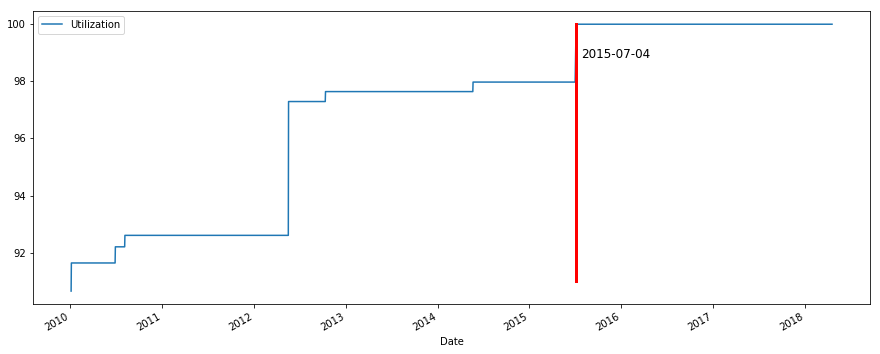

In [169]:
result = pd.read_excel('QQQ_alldata.xlsx')
result['Potential'] = 0
result_c = result.copy()
result_c.replace(np.NaN, 0, inplace = True)

for i, data in result_c.iterrows():
    addition = 0
    for ticker in tickers:
        addition = addition + bool(result_c.loc[i,ticker]) * result_c.loc[i,ticker + ' weight']
    result_c.loc[i,'Potential'] = addition

result_c.plot(x = 'Date', y = 'Potential', figsize = (15,6), label = 'Utilization')
plt.plot(np.repeat(pd.Timestamp(2015, 7, 4),10), range(91,101), 'r', linewidth=3)
plt.text(pd.Timestamp(2015, 7, 25), 98.8, '2015-07-04', fontsize=12)
plt.show()